# The Music of the Sphere: Fourier Series Representation of the Horizon-scale Potential

*Phil Marshall and Roger Blandford, August 2015*

In this notebook we look at some simulated potential fields, and predict the CMB temperature map from them.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import beatbox
import healpy as hp
import numpy as np

/Users/pjm/lsst/DarwinX86/anaconda/2.1.0-4-g35ca374/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## 1. Generating and Visualizing a 3D Potential

Our plan is to use a simple Fourier series, with terms lying within some sphere in k-space, to represent the potential on horizon scales. Let's instantiate such a "beatbox" universe and generate a Gaussian random potential field in it.

In [3]:
We = beatbox.Universe()
We.generate_a_random_potential_field(nmax=6)

Generated  924  potential Fourier coefficients
 Built potential grid, with dimensions  (41, 41, 41)  and mean value  0.0 +/- 31.0


Now, let's visualize the 3D potentials, with `yt`. We're trying to make a plot like [this one](http://yt-project.org/doc/_images/vr_sample.jpg), as shown in the [volume rendering tutorial](http://yt-project.org/doc/visualizing/volume_rendering.html). [This `gist` (from Sam Skillman)](https://gist.github.com/samskillman/0e574d1a4f67d3a3b1b1) uses a development version of `yt` to do the rendering, but does show how to use `yt` data structures.

In [4]:
# !pip install --upgrade Cython
# !pip install --upgrade yt

In [5]:
import yt 

# yt.visualization.color_maps.show_colormaps()

yt : [INFO     ] 2015-10-15 09:04:46,716 Parameters: current_time              = 0.0
yt : [INFO     ] 2015-10-15 09:04:46,717 Parameters: domain_dimensions         = [41 41 41]
yt : [INFO     ] 2015-10-15 09:04:46,717 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2015-10-15 09:04:46,719 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2015-10-15 09:04:46,720 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2015-10-15 09:04:46,832 Loading field plugins.
yt : [INFO     ] 2015-10-15 09:04:46,834 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2015-10-15 09:04:46,836 Loaded astro (15 new fields)
yt : [INFO     ] 2015-10-15 09:04:46,838 Loaded cosmology (22 new fields)
yt : [INFO     ] 2015-10-15 09:04:46,839 Loaded fluid (64 new fields)
yt : [INFO     ] 2015-10-15 09:04:46,843 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2015-10-15 09:04:46,846 Loaded geometric (112 new fields)
yt : [INFO     ] 2015-10-15 09:04:46,8

Extrema of ds phi: 0.0 dimensionless 263.360652785 dimensionless
Extrema after symmetrizing: 0.0 282.169806321


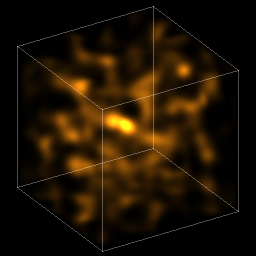

In [6]:
We.show_potential_with_yt(output='test.png',angle=1.6)

from IPython.display import Image
Image('test.png',width=600)

Hmm - I don't see too many layers! The code that makes this plot is here:

In [ ]:
# %load -n We.show_potential_with_yt
    def show_potential_with_yt(self,output='phi.png',angle=1.0):
        """
        Visualize the gravitational potential using yt. We're after something
        like http://yt-project.org/doc/_images/vr_sample.jpg - described
        at http://yt-project.org/doc/visualizing/volume_rendering.html
        """

        # Load the potential field into a yt data structure,
        # offsetting such that minimum value is zero:
        offset = np.abs(np.min(self.phi))
        ds = yt.load_uniform_grid(dict(phi=self.phi+offset), self.phi.shape)

        # Here's Sam's gist, from https://gist.github.com/samskillman/0e574d1a4f67d3a3b1b1
        #   im, sc = yt.volume_render(ds, field='phi')
        #   sc.annotate_domain(ds)
        #   sc.annotate_axes()
        #   im = sc.render()
        #   im.write_png(output, background='white')
        # volume_render is not yet available, though.

        # Following the example at http://yt-project.org/doc/visualizing/volume_rendering.html

        # Set minimum and maximum of plotting range, taking offset
        # into account so that zero appears in center of color map:
        mi, ma = ds.all_data().quantities.extrema('phi')
        print "Extrema of ds phi:",mi,ma
        mi -= offset
        ma -= offset
        ma = np.max(np.abs([mi,ma]))
        mi = -ma + offset
        ma += offset
        print "Extrema after symmetrizing:", mi,ma

        # Instantiate the ColorTransferFunction.
        tf = yt.ColorTransferFunction((mi, ma))

        # Set up the camera parameters: center, looking direction, width, resolution
        c = (ds.domain_right_edge + ds.domain_left_edge)/2.0
        L = np.array([angle, 1.0, 1.0])
        W = ds.quan(1.6, 'unitary')
        N = 256

        # Create a camera object
        cam = ds.camera(c, L, W, N, tf, fields=['phi'])

        # Now let's add some isocontours, and take a snapshot:
        tf.add_layers(21, colormap='BrBG')
        im = cam.snapshot(output)

        # Add the domain box to the image:
        nim = cam.draw_domain(im)

        # Save the image to a file:
        nim.write_png(output)

        return

## 2. Verifying that Phil's Python agrees with Roger's Mathematica code

This is [issue 8](https://github.com/rogerblandford/Music/issues/8).

Now, convert the Fourier coefficients `fn` into `alm`'s, using the appropriate response matrix.

In [25]:
# We.transform_3D_potential_fourier_series_into_T_spherical_harmonics(lmax=3)
# We.show_CMB_T_map(from_perspective_of="observer")